## Imports

In [122]:
import os
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rc('font', family='Georgia')

from generalist_cmaes_config import ENEMY_SETS, NGEN

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Folders for loading data for each algorithm

In [123]:
CMAES_DATAPATH = os.path.join('data', 'cmaes')
NEAT_DATAPATH = os.path.join('data', 'neat')

Unpack the enemy sets

In [124]:
ENEMY_SET_1 = ENEMY_SETS['set_1']
ENEMY_SET_2 = ENEMY_SETS['set_2']

Folder for saving the results (figures)

In [125]:
FIGURE_PATH = os.path.join('figures', 'generalist')
os.makedirs(FIGURE_PATH, exist_ok=True)

## 0. Competition submission

In [126]:
gains = np.load(os.path.join(CMAES_DATAPATH, "set_1", "hp_crit_mean_of_max", "best_gains.npy"))
print(gains)

optimal_index = np.argmax(gains)

[-116.6   50.8   30.    64.4 -112.   -38.4  -82.4   31.8 -154.6  272.4]


In [127]:
best_individuals = np.load(os.path.join(CMAES_DATAPATH, "set_1", "hp_crit_mean_of_max", "train_best_individuals.npy"))
best_individuals[-1].shape

from generalist_cmaes_best_gains import create_singlemode_environment
from generalist_cmaes_config import CONTROLLER

total_gain = 0.0

# for enemy in range(1,9):
#     env = create_singlemode_environment('', enemy, CONTROLLER)
#     env.player_controller.set_weights(best_individuals[optimal_index], 10)
#     _, pl, el, _ = env.play()
#     print(f"Gain #{enemy} = {np.round(pl - el, 1)}")
#     total_gain += pl - el

# print(f"Total gain = {np.round(total_gain, 1)}")
# np.savetxt("105.txt", best_individuals[optimal_index])

## Figure 1: Fitness comparison

This figure presents a comparison of fitness of generalist agents trained with two evolutionary algorithms: CMAES and NEAT across all generations.

### Load CMAES fitness data

In [128]:
cmaes_data = np.array([
    np.load(os.path.join(CMAES_DATAPATH, "set_1", "hp_crit_mean_of_max", "train_all_fitnesses.npy"))[:,:NGEN,:],
    np.load(os.path.join(CMAES_DATAPATH, "set_2", "hp_crit_mean_of_max", "train_all_fitnesses.npy"))[:,:NGEN,:]
])

print(cmaes_data.shape)

(2, 10, 50, 58)


Obtain maximums, HOF-maximums and means of fitnesses for each generation

In [129]:
# Max fitness among individuals
cmaes_max = np.max(cmaes_data, axis=3)
print(cmaes_max.shape)

# Hall-of-fame variant instead of generational max
cmaes_hof = np.maximum.accumulate(cmaes_max, axis=2)
print(cmaes_hof.shape)

# Mean fitness among individuals
cmaes_mean = np.mean(cmaes_data, axis=3)
print(cmaes_mean.shape)

(2, 10, 50)
(2, 10, 50)
(2, 10, 50)


### Load NEAT fitness data

In [130]:
neat_data = np.array([
    np.load(os.path.join(NEAT_DATAPATH, "set_1", "all_fitnesses_static.npy")),
    np.load(os.path.join(NEAT_DATAPATH, "set_2", "all_fitnesses_static.npy"))
])

print(neat_data.shape)

(2, 10, 50, 352)


Obtain maximums and means of fitnesses for each generation

In [131]:
# Max fitness among individuals
neat_max = np.nanmax(neat_data, axis=3)
print(neat_max.shape)

# Mean fitness among individuals
neat_mean = np.nanmean(neat_data, axis=3)
print(neat_mean.shape)

(2, 10, 50)
(2, 10, 50)


### Plotting

In [132]:
def plot_mean_with_sd(ax, xx, means, sds, color="blue", label=""):
    """
    Helper function for plotting mean values with standard deviations
    """
    line = ax.plot(xx, means, color=color, linestyle="solid", lw=1.8)
    ax.fill_between(xx, means + sds, means - sds, color=color, alpha=0.2, edgecolor=color, linewidth=0.0)
    ax.plot(xx, means + sds, color=color, linestyle="solid", lw=0.5, alpha=0.5)
    ax.plot(xx, means - sds, color=color, linestyle="solid", lw=0.5, alpha=0.5)

    return line[0]

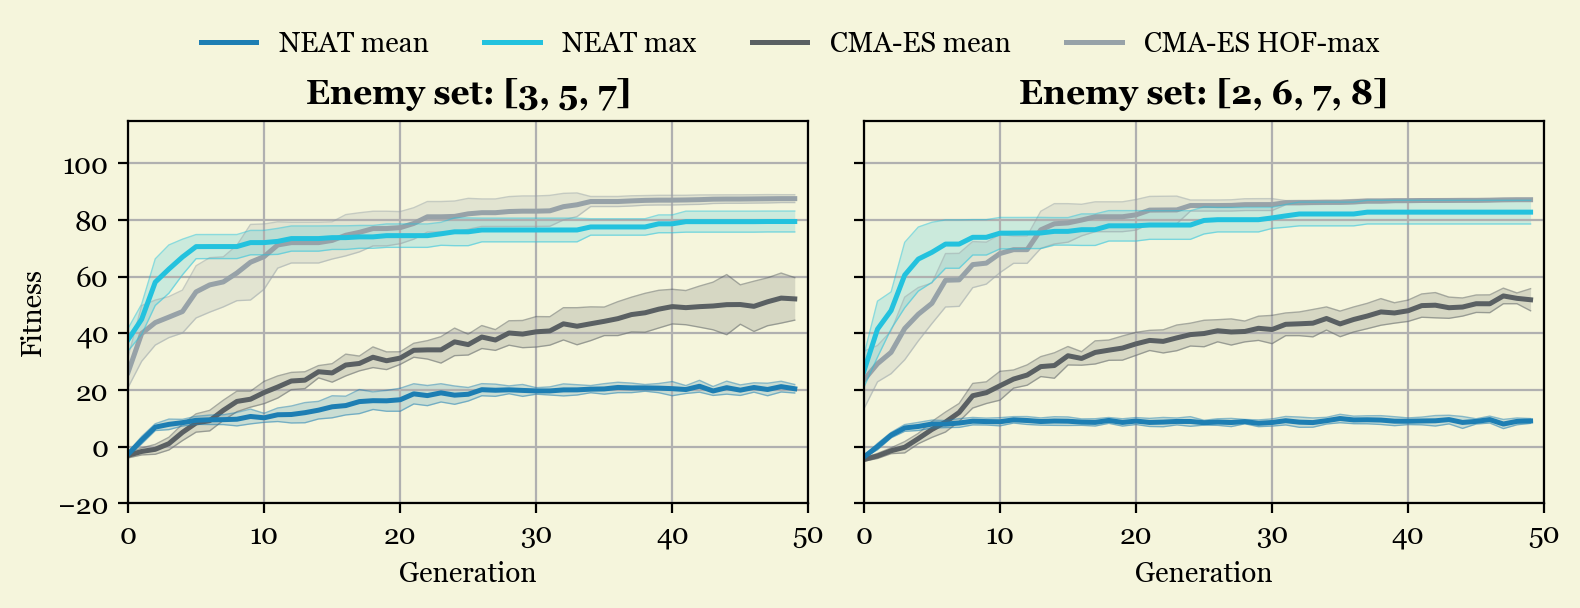

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200, sharey=True)
fig.patch.set_facecolor('beige')

# Plot formatting
for (i, enemy_set) in enumerate([ENEMY_SET_1, ENEMY_SET_2]):
    axes[i].set_ylim(-20, 115)
    axes[i].set_yticks(np.arange(-20, 101, 20))

    axes[i].set_facecolor('beige')

    if i == 0:
        axes[i].set_ylabel("Fitness")
        
    axes[i].set_xlim(0, NGEN)
    axes[i].set_xticks(np.arange(0, NGEN + 1, 10))
    axes[i].set_xlabel("Generation")
    axes[i].set_title(f"Enemy set: {enemy_set}", weight="bold")
    axes[i].grid()

lines = []
labels = []
for i in range(2):
    # line1 = axes[i].errorbar(range(NGEN), neat_avg_mean[i], yerr=neat_sd_mean[i], alpha=0.6, lw=1.2, color="red", label="NEAT mean")
    # line2 = axes[i].errorbar(range(NGEN), neat_avg_max[i], yerr=neat_sd_max[i], alpha=0.6, lw=1.2, color="darkred", label="NEAT max")
    # line3 = axes[i].errorbar(range(NGEN), np.mean(cmaes_mean[i], axis=0), yerr=np.std(cmaes_mean[i], axis=0), alpha=0.6, lw=1.2, color="royalblue", label="CMAES mean")
    # line4 = axes[i].errorbar(range(NGEN), np.mean(cmaes_max[i], axis=0), yerr=np.std(cmaes_max[i], axis=0), alpha=0.6, lw=1.2, color="darkblue", label="CMAES max")
    # line5 = axes[i].errorbar(range(NGEN), np.mean(cmaes_hof[i], axis=0), yerr=np.std(cmaes_hof[i], axis=0), alpha=0.6, lw=1.2, color="green", label="CMAES HOF-max")

    line3 = plot_mean_with_sd(axes[i], range(NGEN), np.mean(cmaes_mean[i], axis=0), np.std(cmaes_mean[i], axis=0), color="#5a6063", label="CMAES-mean")
    # line4 = plot_mean_with_sd(axes[i], range(NGEN), np.mean(cmaes_max[i], axis=0), np.std(cmaes_max[i], axis=0), color="#565759", label="CMAES-max")
    line4 = plot_mean_with_sd(axes[i], range(NGEN), np.mean(cmaes_hof[i], axis=0), np.std(cmaes_hof[i], axis=0), color="#97a2a8", label="CMAES HOF-max")

    line1 = plot_mean_with_sd(axes[i], range(NGEN), np.mean(neat_mean[i], axis=0), np.std(neat_mean[i], axis=0), color="#1d7eb3", label="NEAT-mean")
    line2 = plot_mean_with_sd(axes[i], range(NGEN), np.mean(neat_max[i], axis=0), np.std(neat_max[i], axis=0), color="#23c2de", label="NEAT-max")

    if i == 0:
        lines.extend([line1, line2, line3, line4])
        labels.extend(["NEAT mean", "NEAT max", "CMA-ES mean", "CMA-ES HOF-max"])

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(lines, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02), fontsize=10, frameon=False)
# fig.savefig("figures/convergence.png", dpi=400)
plt.show()

## Figure 2: Gain boxplots

### Load CMAES gain data

In [134]:
cmaes_data = np.array([
    np.load(os.path.join(CMAES_DATAPATH, "set_1", "hp_crit_mean_of_max", "best_gains.npy")),
    np.load(os.path.join(CMAES_DATAPATH, "set_2", "hp_crit_mean_of_max", "best_gains.npy"))
])

print(cmaes_data.shape)

(2, 10)


### Load NEAT gain data

In [135]:
neat_data = np.array([
    np.load(os.path.join(NEAT_DATAPATH, "set_1", "best_gains.npy")),
    np.load(os.path.join(NEAT_DATAPATH, "set_2", "best_gains.npy"))
])

print(neat_data.shape)

(2, 10)


### Plotting

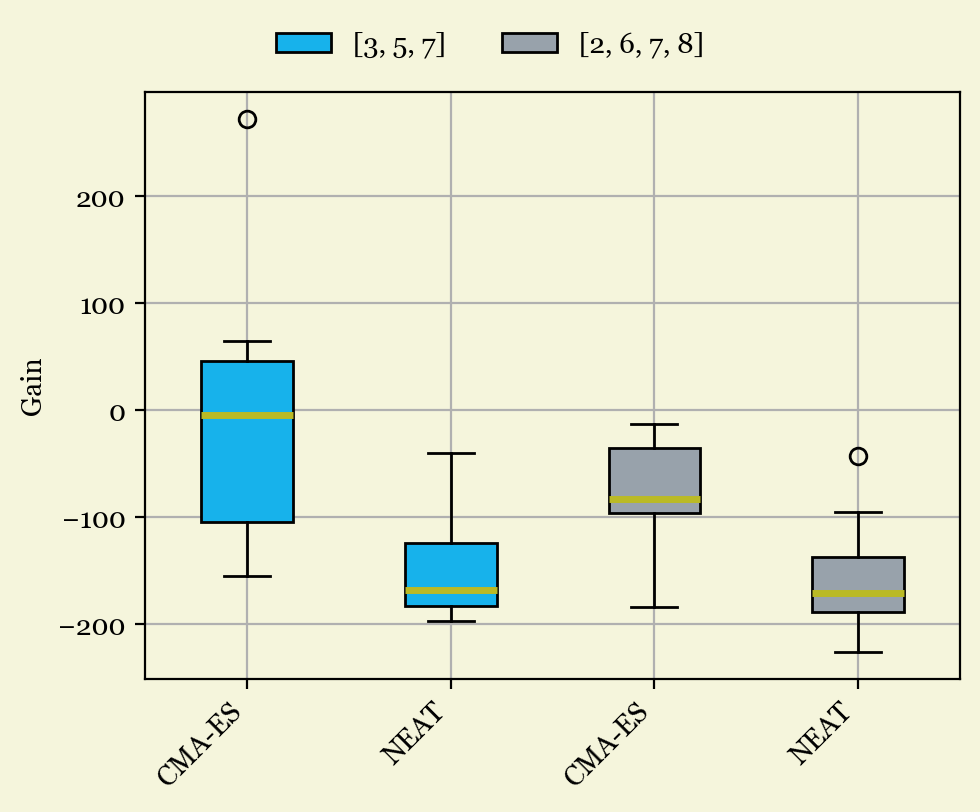

In [136]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
fig.patch.set_facecolor('beige')

# Group up data, corresponding labels and boxplot colors
all_gains = [cmaes_data[0], neat_data[0], cmaes_data[1], neat_data[1]]
labels = ['CMA-ES', 'NEAT', 'CMA-ES', 'NEAT']
colors = ['#17b2eb', '#17b2eb', '#98a2ab', '#98a2ab']

# Style of median line
medianprops = dict(linestyle='-', linewidth=2.5, color='#baba25')

# Create the boxplot
bplot = ax.boxplot(all_gains, patch_artist=True, medianprops=medianprops)

# Matplotlib formatting
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_facecolor('beige')
ax.set_ylabel("Gain")
ax.grid()

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

fig.tight_layout(rect=[0, 0, 1, 0.95])

legend = fig.legend([bplot['boxes'][0], bplot['boxes'][2]], [ENEMY_SET_1, ENEMY_SET_2], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02), fontsize=10, frameon=False)
frame = legend.get_frame()
frame.set_facecolor('beige')
frame.set_edgecolor('beige')
# fig.savefig("figures/test_gain.png", dpi=400)
plt.show()

## Figure 3: Time efficiency

### Read CMAES time data

In [137]:
cmaes_time = np.array([
    np.load(os.path.join(CMAES_DATAPATH, "set_1", "hp_crit_mean", "train_all_times_elapsed.npy"))[:,:NGEN],
    np.load(os.path.join(CMAES_DATAPATH, "set_2", "hp_crit_mean", "train_all_times_elapsed.npy"))[:,:NGEN]
])

# Normalize to miliseconds ????
# TODO: DELETE
cmaes_time = cmaes_time
print(cmaes_time.shape)

cmaes_cumtime = np.cumsum(cmaes_time, axis=2)
print(cmaes_cumtime.shape)

(2, 10, 50)
(2, 10, 50)


### Read NEAT time data

In [138]:
neat_time = np.array([
    np.load(os.path.join(NEAT_DATAPATH, "set_1", "all_times_elapsedstatic.npy"))[:,:NGEN],
    np.load(os.path.join(NEAT_DATAPATH, "set_2", "all_times_elapsedstatic.npy"))[:,:NGEN]
])

# Normalize to miliseconds
neat_time = neat_time
print(neat_time.shape)

# Cumulative time elapsed
neat_cumtime = np.cumsum(neat_time, axis=2)
print(neat_cumtime.shape)

(2, 10, 50)
(2, 10, 50)


### Plotting

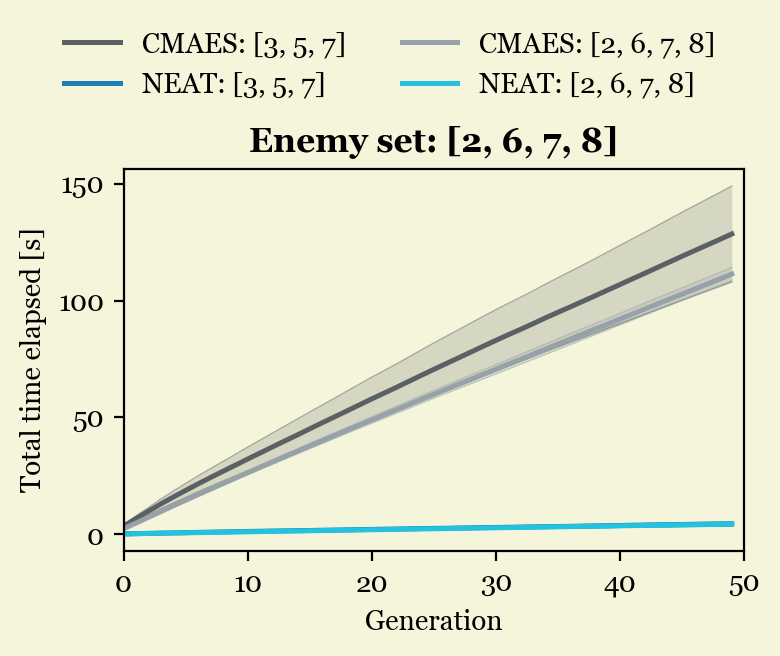

In [139]:
fig, axis = plt.subplots(1, 1, figsize=(4, 3), dpi=200)
fig.patch.set_facecolor('beige')

# Plot formatting
for (i, enemy_set) in enumerate([ENEMY_SET_1, ENEMY_SET_2]):
    # axes[i].set_ylim(-20, 115)
    # axes[i].set_yticks(np.arange(-20, 101, 20))

    axis.set_facecolor('beige')

    if i == 0:
        axis.set_ylabel("Total time elapsed [s]")
        
    axis.set_xlim(0, NGEN)
    axis.set_xticks(np.arange(0, NGEN + 1, 10))
    axis.set_xlabel("Generation")
    axis.set_title(f"Enemy set: {enemy_set}", weight="bold")
    axis.grid()

lines = []
labels = []

line1 = plot_mean_with_sd(axis, range(NGEN), np.mean(cmaes_cumtime[0], axis=0), np.std(cmaes_cumtime[0], axis=0), color="#5a6063", label=f"CMAES: {ENEMY_SET_1}")
line2 = plot_mean_with_sd(axis, range(NGEN), np.mean(neat_cumtime[0], axis=0), np.std(neat_cumtime[0], axis=0), color="#1d7eb3", label=f"NEAT: {ENEMY_SET_1}")

line3 = plot_mean_with_sd(axis, range(NGEN), np.mean(cmaes_cumtime[1], axis=0), np.std(cmaes_cumtime[1], axis=0), color="#97a2a8", label=f"CMAES: {ENEMY_SET_2}")
line4 = plot_mean_with_sd(axis, range(NGEN), np.mean(neat_cumtime[1], axis=0), np.std(neat_cumtime[1], axis=0), color="#23c2de", label=f"NEAT: {ENEMY_SET_2}")

lines.extend([line1, line2, line3, line4])
labels.extend([f"CMAES: {ENEMY_SET_1}", f"NEAT: {ENEMY_SET_1}", f"CMAES: {ENEMY_SET_2}", f"NEAT: {ENEMY_SET_2}"])

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(lines, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.10), fontsize=10, frameon=False)
# fig.savefig("figures/convergence.png", dpi=400)
plt.show()

In [144]:
print(cmaes_time.shape)
print(cmaes_hof.shape)

cmaes_hofdiff = np.roll(cmaes_hof, -1, axis=2) - cmaes_hof
print(cmaes_hofdiff)

(2, 10, 50)
(2, 10, 50)
[[[ 0.00000000e+00  0.00000000e+00  6.10236151e+00  0.00000000e+00
    2.74766016e+00  0.00000000e+00  3.64359219e+00  0.00000000e+00
    8.71361765e-01  0.00000000e+00  1.86087890e+01  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  9.98538913e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  8.09872244e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  2.36465126e+00
    0.00000000e+00  0.00000000e+00  1.44264958e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00 -5.25667925e+01]
  [ 1.38928761e+01  0.00000000e+00  2.73694672e+00  1.96221855e+01
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  

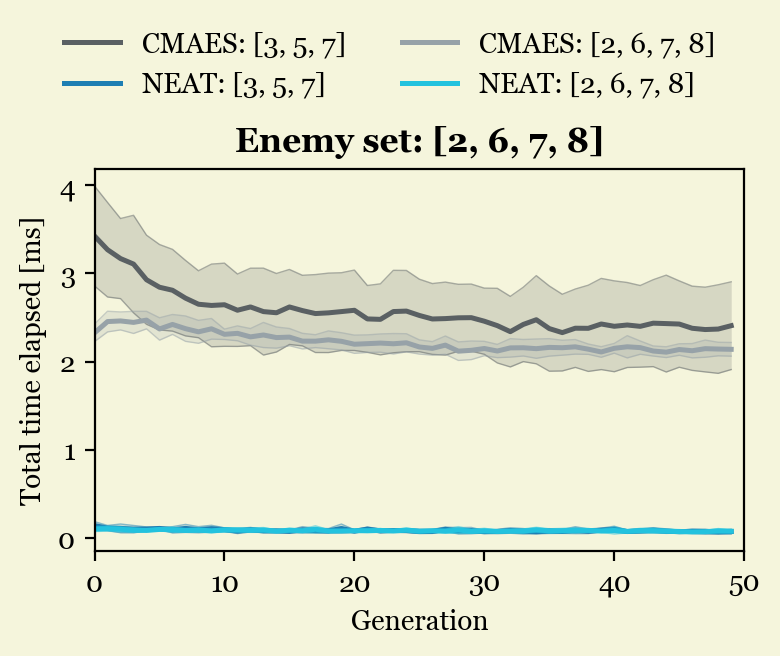

In [141]:
fig, axis = plt.subplots(1, 1, figsize=(4, 3), dpi=200)
fig.patch.set_facecolor('beige')

# Plot formatting
for (i, enemy_set) in enumerate([ENEMY_SET_1, ENEMY_SET_2]):
    # axes[i].set_ylim(-20, 115)
    # axes[i].set_yticks(np.arange(-20, 101, 20))

    axis.set_facecolor('beige')

    if i == 0:
        axis.set_ylabel("Total time elapsed [ms]")
        
    axis.set_xlim(0, NGEN)
    axis.set_xticks(np.arange(0, NGEN + 1, 10))
    axis.set_xlabel("Generation")
    axis.set_title(f"Enemy set: {enemy_set}", weight="bold")
    axis.grid()

lines = []
labels = []

line1 = plot_mean_with_sd(axis, range(NGEN), np.mean(cmaes_time[0], axis=0), np.std(cmaes_time[0], axis=0), color="#5a6063", label=f"CMAES: {ENEMY_SET_1}")
line2 = plot_mean_with_sd(axis, range(NGEN), np.mean(neat_time[0], axis=0), np.std(neat_time[0], axis=0), color="#1d7eb3", label=f"NEAT: {ENEMY_SET_1}")

line3 = plot_mean_with_sd(axis, range(NGEN), np.mean(cmaes_time[1], axis=0), np.std(cmaes_time[1], axis=0), color="#97a2a8", label=f"CMAES: {ENEMY_SET_2}")
line4 = plot_mean_with_sd(axis, range(NGEN), np.mean(neat_time[1], axis=0), np.std(neat_time[1], axis=0), color="#23c2de", label=f"NEAT: {ENEMY_SET_2}")

lines.extend([line1, line2, line3, line4])
labels.extend([f"CMAES: {ENEMY_SET_1}", f"NEAT: {ENEMY_SET_1}", f"CMAES: {ENEMY_SET_2}", f"NEAT: {ENEMY_SET_2}"])

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(lines, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.10), fontsize=10, frameon=False)
# fig.savefig("figures/convergence.png", dpi=400)
plt.show()